Saved: segmented_characters/char_1.png


Saved: segmented_characters/char_2_1.png


Saved: segmented_characters/char_2_2.png


Saved: segmented_characters/char_2_3.png


Saved: segmented_characters/char_2_4.png


Saved: segmented_characters/char_3.png


Saved: segmented_characters/char_4.png


Saved: segmented_characters/char_5.png


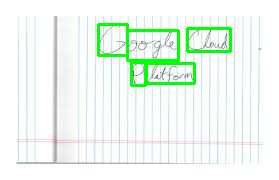

Character segmentation completed!


In [ ]:
import cv2
import os
import numpy as np
from google.colab.patches import cv2_imshow

output_folder = "segmented_characters"
os.makedirs(output_folder, exist_ok=True)

image_path = '/content/download.jpg'
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
min_contour_area = 100
max_contour_area = 1000
filtered_contours = [
    c for c in contours if min_contour_area < cv2.contourArea(c) < max_contour_area
]
filtered_contours = sorted(filtered_contours, key=lambda c: cv2.boundingRect(c)[0])

def split_multi_character_box(roi):
    _, roi_thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    sub_contours, _ = cv2.findContours(roi_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    min_sub_area = 50
    sub_contours = [c for c in sub_contours if cv2.contourArea(c) > min_sub_area]
    sub_contours = sorted(sub_contours, key=lambda c: cv2.boundingRect(c)[0])
    char_images = []
    for sub_contour in sub_contours:
        x, y, w, h = cv2.boundingRect(sub_contour)
        char = roi[y:y+h, x:x+w]
        char_images.append(char)
    return char_images

for i, contour in enumerate(filtered_contours):
    x, y, w, h = cv2.boundingRect(contour)
    roi = thresh[y:y+h, x:x+w]
    if w > 50:
        characters = split_multi_character_box(roi)
        for j, char in enumerate(characters):
            char_resized = cv2.resize(char, (28, 28), interpolation=cv2.INTER_AREA)
            char_filename = os.path.join(output_folder, f'char_{i + 1}_{j + 1}.png')
            cv2.imwrite(char_filename, char_resized)
            print(f'Saved: {char_filename}')
            cv2_imshow(char_resized)
    else:
        char_resized = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
        char_filename = os.path.join(output_folder, f'char_{i + 1}.png')
        cv2.imwrite(char_filename, char_resized)
        print(f'Saved: {char_filename}')
        cv2_imshow(char_resized)

for contour in filtered_contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

cv2_imshow(image)
print("Character segmentation completed!")


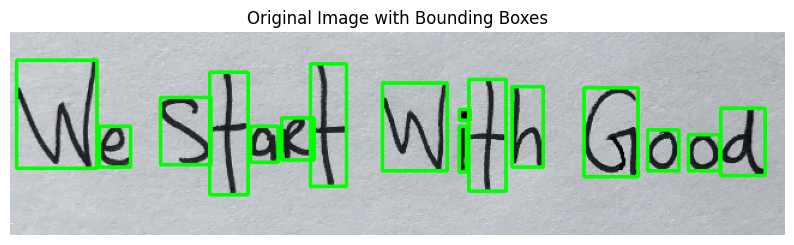

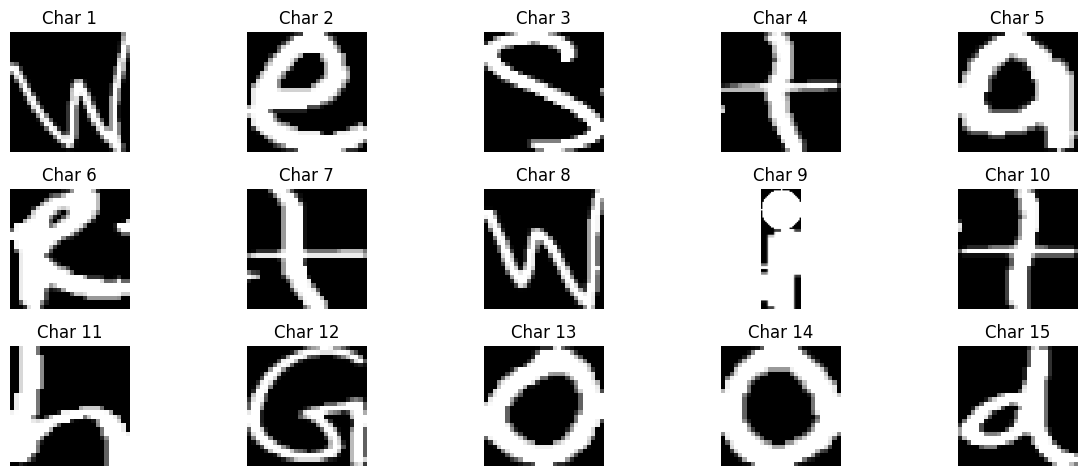

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

image_path = "/content/download.jpg"
image = cv2.imread(image_path)
if image is None:
    raise ValueError("Image not found or unable to load.")

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
_, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

output_folder = "segmented_characters"
os.makedirs(output_folder, exist_ok=True)

contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

image_with_boxes = image.copy()
min_contour_area = 50
max_contour_area = 10000
segmented_characters = []

def split_connected_components(roi):
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(roi, connectivity=8)
    characters = []
    for i in range(1, num_labels):
        x, y, w, h, area = stats[i]
        if area > 10:
            char = roi[y:y+h, x:x+w]
            characters.append((x, char))
    return [c[1] for c in sorted(characters, key=lambda x: x[0])]

contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])

for i, contour in enumerate(contours):
    if min_contour_area < cv2.contourArea(contour) < max_contour_area:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
        roi = thresh[y:y+h, x:x+w]

        if w > 50:
            components = split_connected_components(roi)
        else:
            components = [roi]

        for j, char in enumerate(components):
            char_resized = cv2.resize(char, (28, 28), interpolation=cv2.INTER_AREA)
            segmented_characters.append(char_resized)
            char_filename = os.path.join(output_folder, f"char_{i + 1}_{j + 1}.png")
            cv2.imwrite(char_filename, char_resized)

char_9 = segmented_characters[8]
char_10 = segmented_characters[9]

side_length = min(char_10.shape)
square_char_10 = char_10[:side_length, :side_length]

mask = np.zeros_like(square_char_10)
center = (side_length // 2, side_length // 2)
radius = side_length // 2
cv2.circle(mask, center, radius, (255), thickness=-1)

circle_char_10 = cv2.bitwise_and(square_char_10, mask)
circle_char_10_resized = cv2.resize(circle_char_10, (28, 28), interpolation=cv2.INTER_AREA)

char_9_resized = cv2.resize(char_9, (28, 56), interpolation=cv2.INTER_AREA)

combined_image = np.vstack((circle_char_10_resized, char_9_resized))
segmented_characters[8:10] = [combined_image]

plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.title("Original Image with Bounding Boxes")
plt.axis("off")
plt.show()

plt.figure(figsize=(12, 8))
for idx, char_img in enumerate(segmented_characters):
    plt.subplot(5, 5, idx + 1)
    plt.imshow(char_img, cmap="gray")
    plt.title(f"Char {idx + 1}")
    plt.axis("off")
plt.tight_layout()
plt.show()

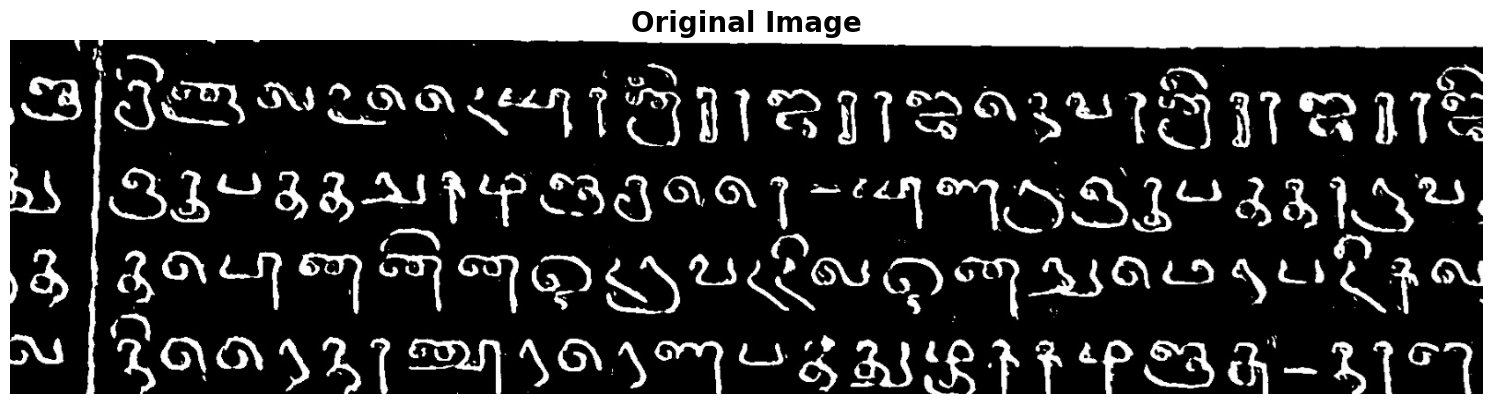

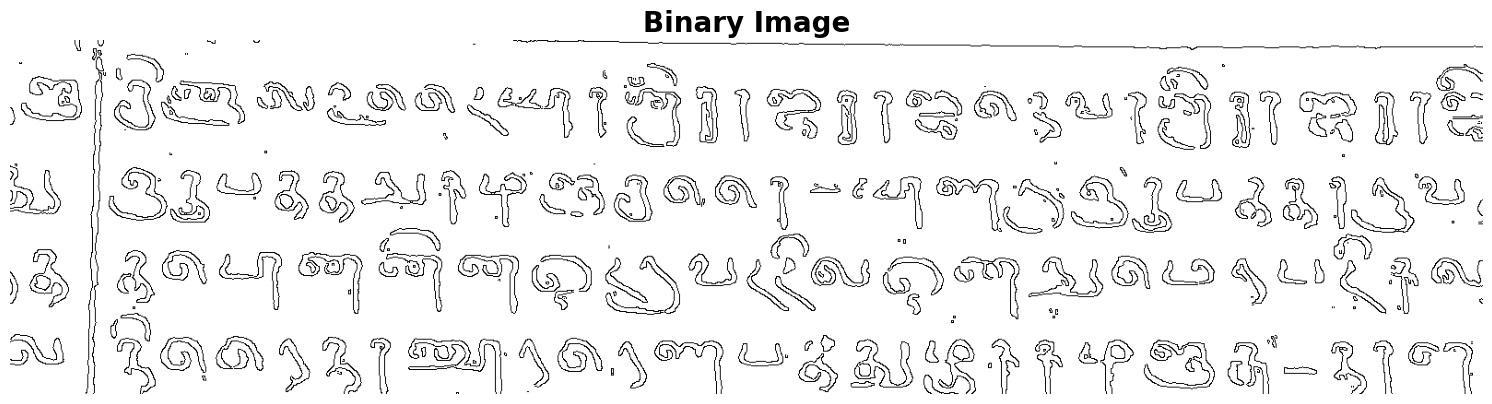

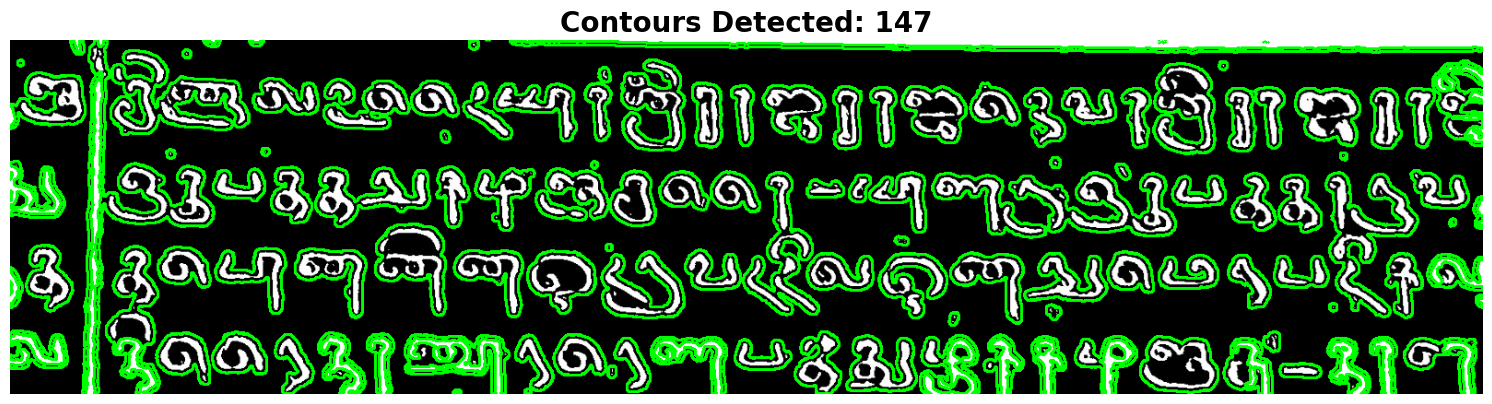

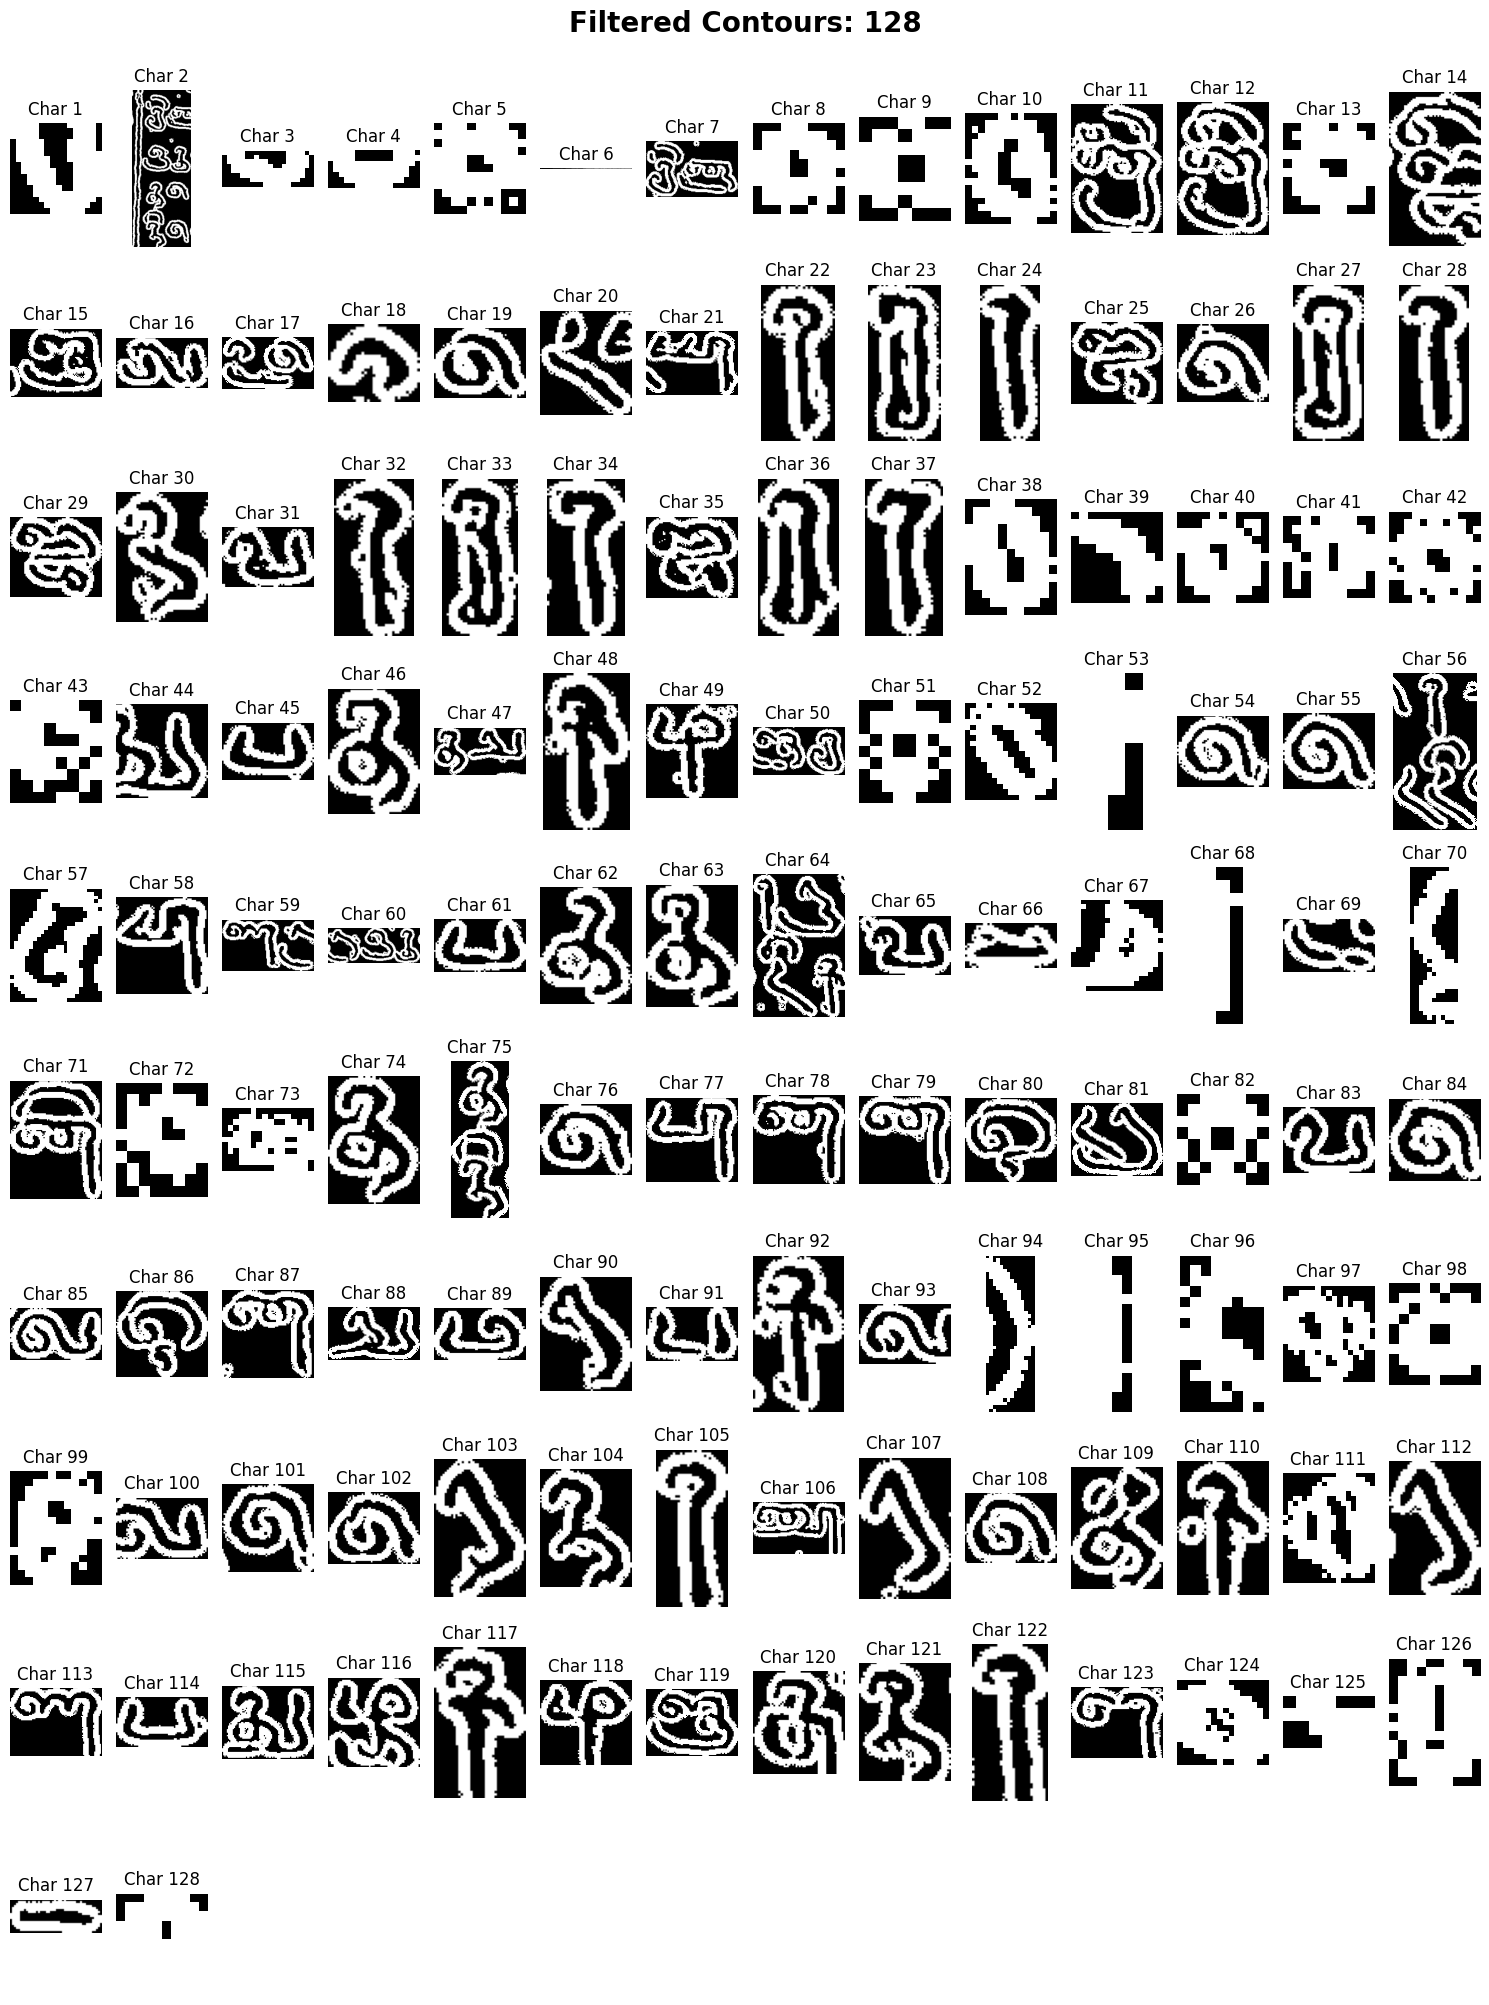

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread("/content/download1.png")
plt.figure(figsize=(19, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image", fontsize=20, fontweight='bold')
plt.axis("off")
plt.show()

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(gray, 50, 150)
_, binary = cv2.threshold(edges, 127, 255, cv2.THRESH_BINARY_INV)
plt.figure(figsize=(19, 10))
plt.imshow(binary, cmap="gray")
plt.title("Binary Image", fontsize=20, fontweight='bold')
plt.axis("off")
plt.show()

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
min_area = 0.00001 * image.shape[0] * image.shape[1]
filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]

sorted_contours = sorted(filtered_contours, key=lambda c: (cv2.boundingRect(c)[1] // 10, cv2.boundingRect(c)[0]))

image_with_contours = image.copy()
cv2.drawContours(image_with_contours, contours, -1, (0, 255, 0), 2)
plt.figure(figsize=(19, 10))
plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
plt.title(f"Contours Detected: {len(contours)}", fontsize=20, fontweight='bold')
plt.axis("off")
plt.show()

extracted_characters = []
for i, cnt in enumerate(sorted_contours):
    x, y, w, h = cv2.boundingRect(cnt)
    roi = binary[y:y+h, x:x+w]
    extracted_characters.append(roi)

n = len(extracted_characters)
cols = 14
rows = n // cols + (n % cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 2))
for i in range(rows * cols):
    ax = axes[i // cols, i % cols]
    if i < n:
        ax.imshow(extracted_characters[i], cmap="gray")
        ax.set_title(f"Char {i+1}")
    ax.axis("off")

plt.suptitle(f"Filtered Contours: {len(filtered_contours)}", fontsize=20, fontweight='bold', y=1)
plt.tight_layout()
plt.show()